# Solutions Task 3
Author: Luis Denninger

In [34]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn 
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg


## Data


In [35]:

tg.tools.set_random_seed(42)

data = tg.data.load_dataset('oxfordpet')


train_dataset = data['train_dataset']
test_dataset = data['test_dataset']

dog_inds = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
cat_inds = [0, 5, 6, 7, 8, 11, 20, 23, 26, 27, 32, 33]

category_names = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau',
    'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees',
    'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher',
    'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard',
    'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]

print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 3680
Test dataset size: 3669


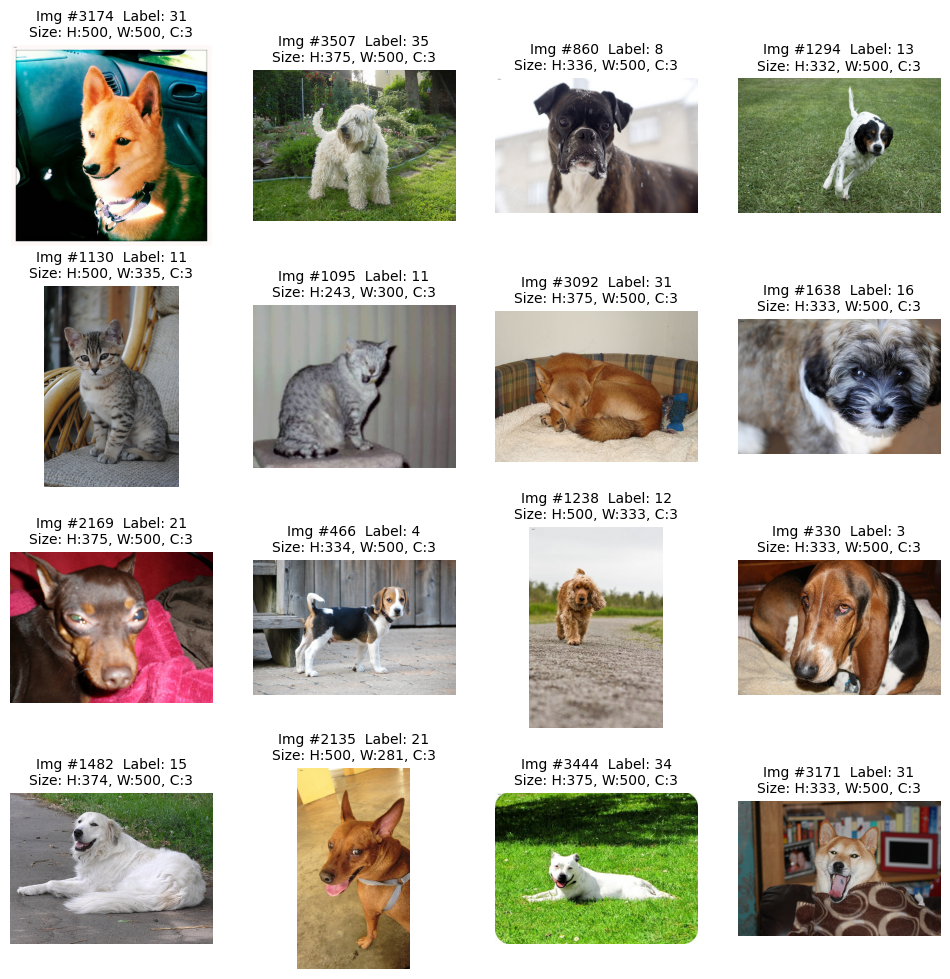

In [36]:
tg.visualization.visualize_dataset(test_dataset)

## Data Augmentation
The images loaded from our dataset are cropped to a uniform image size of 224x244. For the training images we take a random crop of the image and resize it to 224x244. For the test dataset we take a quadratic crop around the center that spans the minimum of the image width and height, to include as much information as possible in the crop. The models that we train "without augmentation" still include augmentation in form of a random crop. The further augmentations applied to the images are:
 - MixUp (alpha: 1.0, probability: 0.5, beta: 1.0)
 - Random Rotation (Maximum Degree: 5)
 - Random Horizontal Flip (probability: 0.3)
 - Color Jitter (brightness: (0.6, 1.4), contrast: (0.6, 1.4), saturation: (0.7, 1.3))
 - Gaussian Blur (kernel size: (5,5), sigma: (0.1, 2.0))

In our experiments, we were not able to get proper results using CutMix. Both implementations taken from our package are provided below.

In [39]:
# Take a random crop and resize the image to 224x224 to enforce the same size for all images to concatenate them to batches.
data_loading_transforms = [ {'type': 'convert_255_to_1','train': True, 'eval': True}, 
                            {'type': 'random_resized_crop', 'size': (224, 224), 'scale': (0.08,1.0), 'ratio': (0.75, 1.3333), 'train': True, 'eval': False}
                             ]

test_data_loading_transforms = [{'type': 'convert_255_to_1','train': True, 'eval': True},
                                {'type': 'dynamic_center_crop', 'train': False, 'eval': True},
                                {'type': 'resize', 'size': (224,224), 'train': False, 'eval': True}]

# All other transformations are applied to batches of images after data loading for higher computational efficiency.

tg.tools.set_random_seed(42)

# Define a custom dataset including the data augmentation and further functions to edit the dataset.
train_augmentation_dataset = tg.data.ImageDataset(train_dataset, data_loading_transforms)
test_augmentation_dataset = tg.data.ImageDataset(test_dataset, test_data_loading_transforms, train_set=False)




### Implementation

These are the implementations of the two advanced data augmentation techniques from our package that are used in our data augmentation pipeline.


#### MixUp

```python

def _mixup(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "mixup: beyond empirical risk minimization" <https://arxiv.org/pdf/1710.09412.pdf>
    """

    device = input[0].device
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]

    target_ohc = torch.nn.functional.one_hot(input[1], num_classes=self.mixup_classes)
    target_pairs_ohc = torch.nn.functional.one_hot(target_pairs, num_classes=self.mixup_classes)

    lam = self.mixup_beta.sample() # sample from beta distribution

    return (lam * input[0] + (1 - lam) * batch_pairs, lam * target_ohc + (1 - lam) * target_pairs_ohc)

```

#### CutMix

```python
def _cutmix(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: 
            "CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features" <https://arxiv.org/pdf/1905.04899.pdf>.
        This code is an adaptation from: https://github.com/clovaai/CutMix-PyTorch
    """

    def _rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
    device = input[0].device
    # generate mixed sample
    lam = self.cutmix_beta.sample() # sample from beta distribution
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]
    bbx1, bby1, bbx2, bby2 = _rand_bbox(batch_pairs.shape, lam)
    batch_pairs[:, :, bbx1:bbx2, bby1:bby2] = batch_pairs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input[0].shape[-1] * input[0].shape[-2]))
    target = torch.nn.functional.one_hot(input[1], num_classes=self.cutmix_classes) * lam + (1 - lam) * torch.nn.functional.one_hot(target_pairs, num_classes=self.cutmix_classes)
    return (batch_pairs, target)


```

In [ ]:
###--- MixUp ---###
# This is the implementation we use throughout the notebook.

def _mixup(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "mixup: beyond empirical risk minimization" <https://arxiv.org/pdf/1710.09412.pdf>
    """

    device = input[0].device
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]

    target_ohc = torch.nn.functional.one_hot(input[1], num_classes=self.mixup_classes)
    target_pairs_ohc = torch.nn.functional.one_hot(target_pairs, num_classes=self.mixup_classes)

    lam = self.mixup_beta.sample() # Sample beta distribution

    return (lam * input[0] + (1 - lam) * batch_pairs, lam * target_ohc + (1 - lam) * target_pairs_ohc)

In [ ]:
###--- MixUp ---###
# This is the implementation we use throughout the notebook.

def _cutmix(self, input: tuple):
    """
        Implementation of the data augmentation technique as described in: "CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features" <https://arxiv.org/pdf/1905.04899.pdf>
        This code is an adaptation from: https://github.com/clovaai/CutMix-PyTorch
    """

    def _rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
    device = input[0].device
    # generate mixed sample
    lam = self.cutmix_beta.sample()
    rand_index = torch.randperm(input[0].shape[0]).to(device)
    target_pairs = input[1][rand_index]
    batch_pairs = input[0][rand_index]
    bbx1, bby1, bbx2, bby2 = _rand_bbox(batch_pairs.shape, lam)
    batch_pairs[:, :, bbx1:bbx2, bby1:bby2] = batch_pairs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input[0].shape[-1] * input[0].shape[-2]))
    target = torch.nn.functional.one_hot(input[1], num_classes=self.cutmix_classes) * lam + (1 - lam) * torch.nn.functional.one_hot(target_pairs, num_classes=self.cutmix_classes)
    return (batch_pairs, target)
  

### Conversion to Reduced Dataset

In [40]:
# Create mapping from original labels to dog (0) and cat (1) labels.
label_mapping = {}
for i in range(37):
    label_mapping[str(i)] = 0 if i in dog_inds else 1
# Remap the categories to dogs and cats within the dataset
train_augmentation_dataset.remap_labels(label_mapping)
test_augmentation_dataset.remap_labels(label_mapping)

# Take random 1000 random cat and 1000 random dog images.
CAT_IMAGES = 1000
DOG_IMAGES = 1000
random_inds = np.arange(len(train_augmentation_dataset))
np.random.shuffle(random_inds)

random_cat_inds = []
random_dog_inds = []
for i in random_inds:
    if len(random_cat_inds) >= CAT_IMAGES and len(random_dog_inds) >= DOG_IMAGES:
        break
    img, label = train_augmentation_dataset[i]
    if label == 0 and len(random_dog_inds) < DOG_IMAGES:
        random_dog_inds.append(i)
    elif label == 1 and len(random_cat_inds) < CAT_IMAGES:
        random_cat_inds.append(i)

train_augmentation_dataset.filter_dataset((random_cat_inds+random_dog_inds))


### Training Dataset

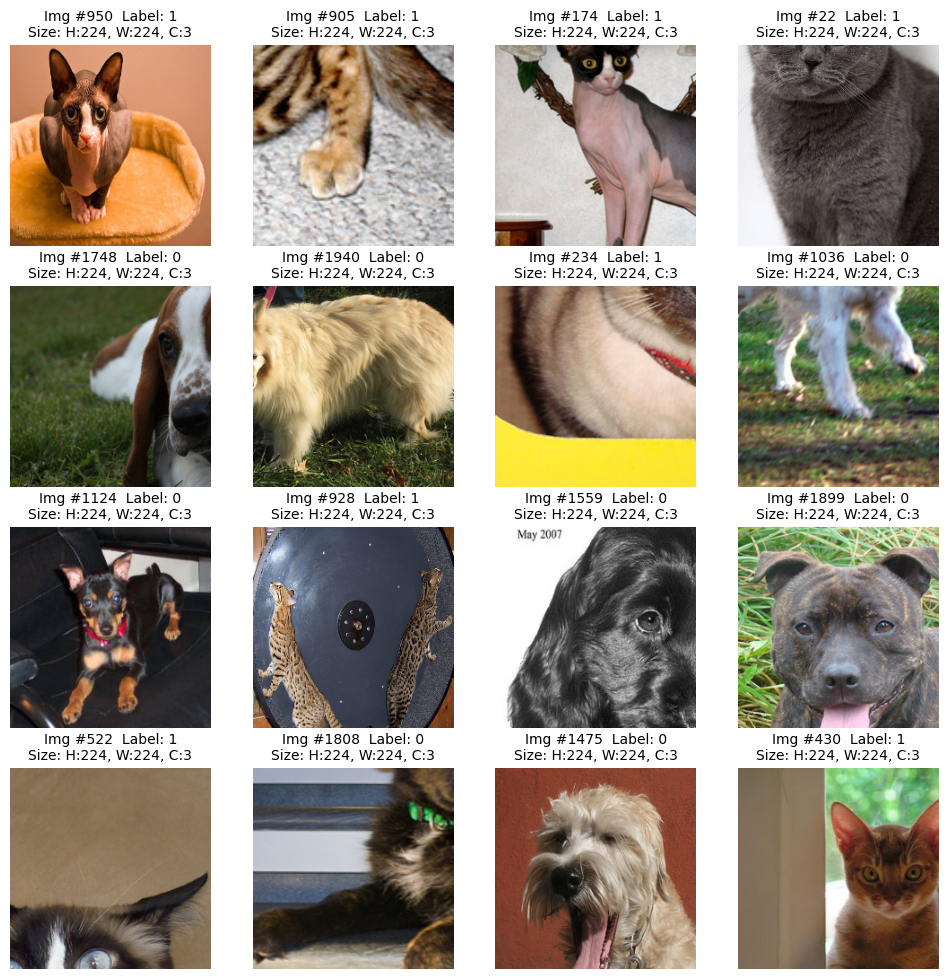

In [41]:
tg.visualization.visualize_dataset(train_augmentation_dataset)

### Test Dataset

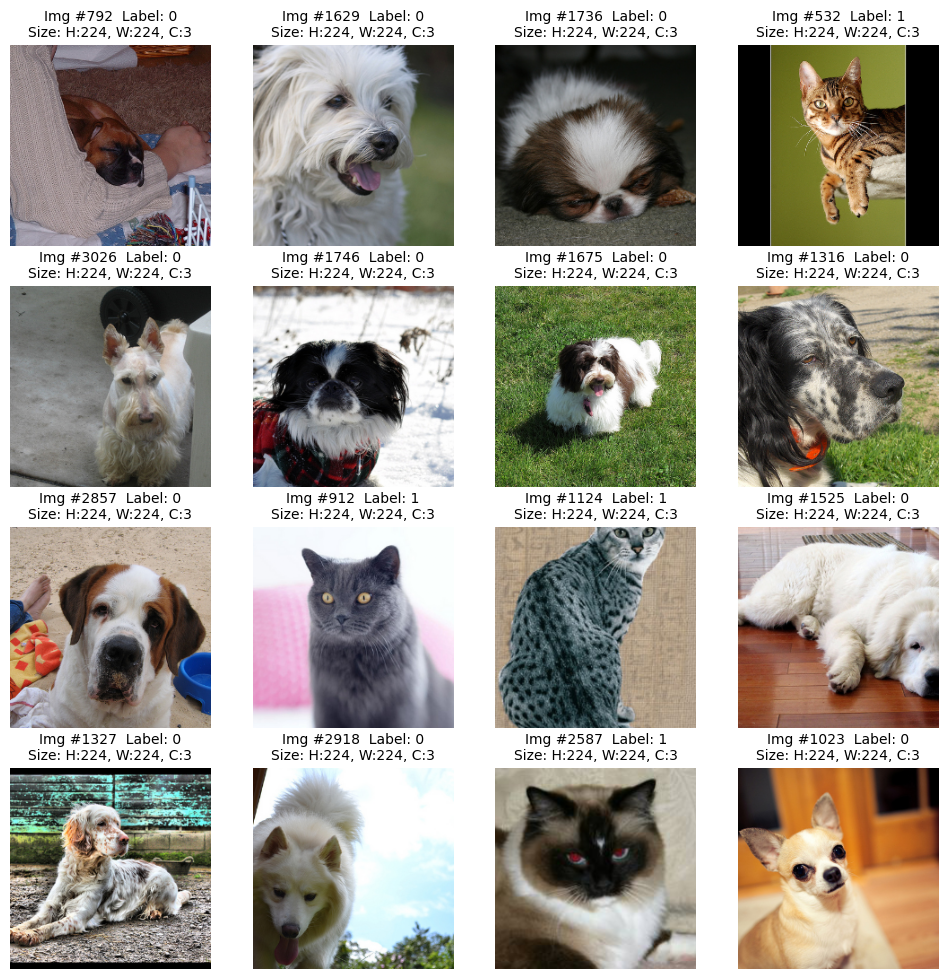

In [42]:
tg.visualization.visualize_dataset(test_augmentation_dataset)


### Augmented Dataset

Here are the final training images from our data augmentation pipeline as described above

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


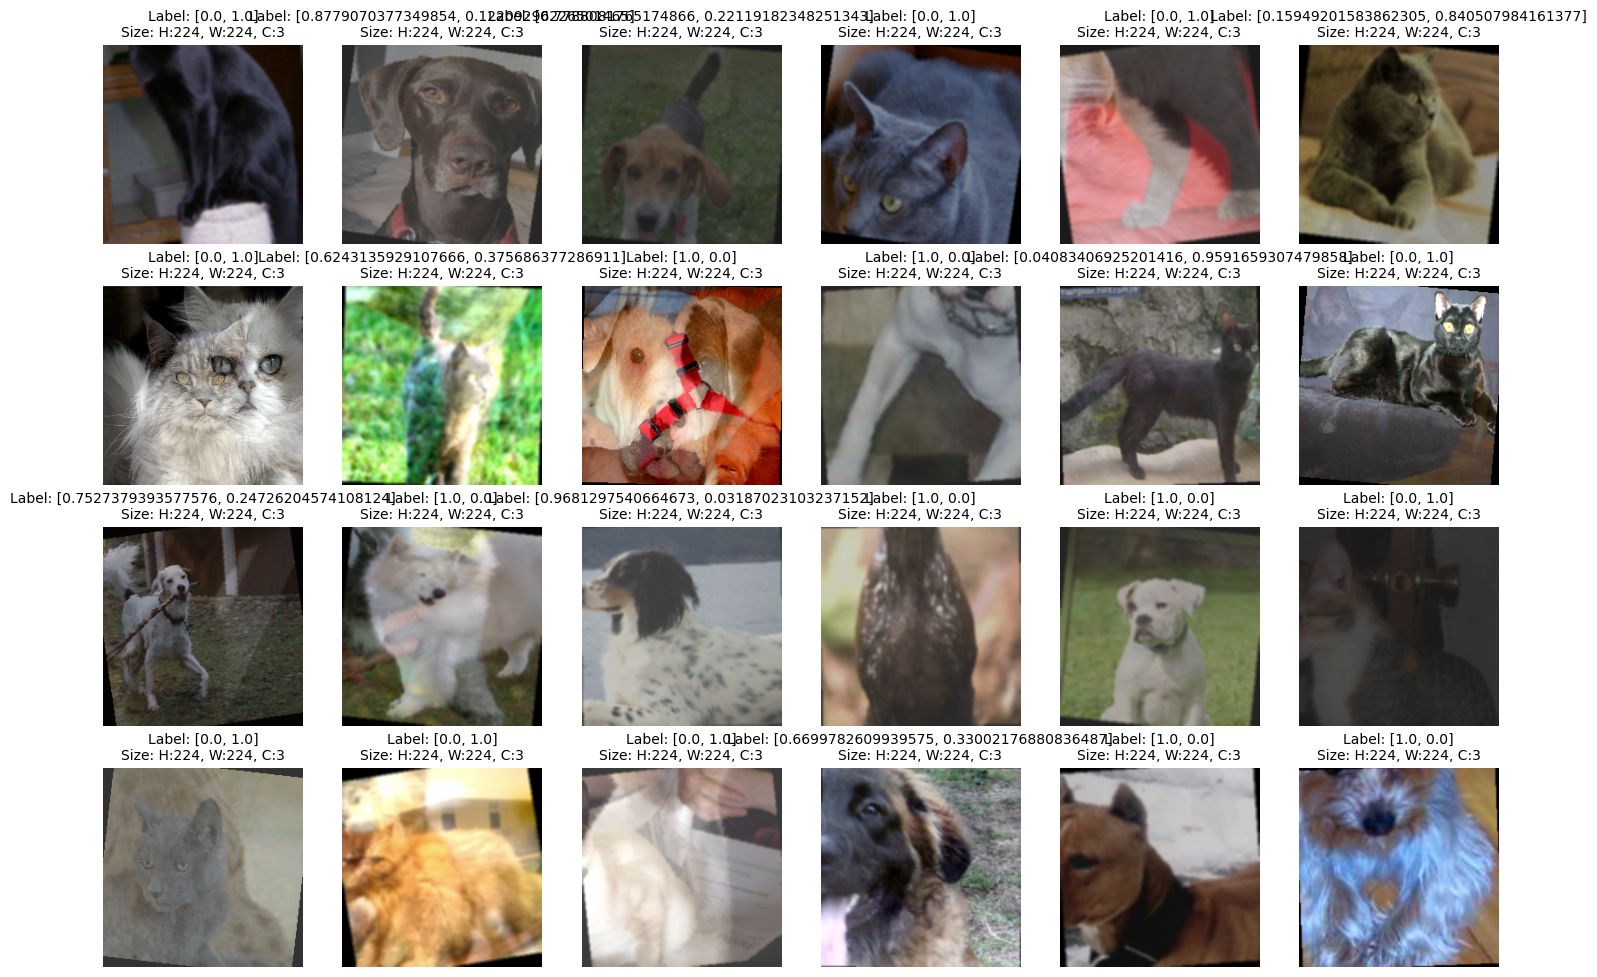

In [43]:

data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.5, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                    ]



data_augmentor = tg.data.ImageDataAugmentor(data_augmentation)
tg.visualization.visualize_dataloader(train_augmentation_dataset, data_augmentor=data_augmentor, layout=(4,6))


## Logging
In the following we will use a logger from our package that logs all defined metrics internalls and to TensorBoard. 
The source code of the logger is provided below.



In [44]:
tBoard_base_log_dir = os.path.join(os.getcwd(), 'data/tensorboard_logs')
if not os.path.exists(tBoard_base_log_dir):
    os.makedirs(tBoard_base_log_dir)

tBoard_log_dir = {}

exp_names = ['resnet', 'resnet_noag', 'vgg', 'vgg_noag', 'mobilenet','mobilenet_noag', 'resnet_finetune', 'resnet_freeze', 'resnet_combined']

for exp_name in exp_names:
    tBoard_log_dir[exp_name] = os.path.join(tBoard_base_log_dir, exp_name)
    if not os.path.exists(tBoard_log_dir[exp_name]):
        os.makedirs(tBoard_log_dir[exp_name])
    





### Logger Implementation 

```python

class _Logger():
    def __init__(self,
                save_dir = None,
                    log_name: str = None,
                        model_config: dict = None,
                            writer: SummaryWriter = None,
                            save_external: bool = True,                                    
                            save_internal: bool = False, 
                                ):
        """
            The module logs the data internally to be accessed later or externally to the disk using TensorBoard.
            It can be simply implemented in the training pipeline to handle all logging tasks.

            Arguments:
                save_dir (str): The path to save tensorboard logs.
                log_name (str): The suffix of the name of the log.
                model_config (dict): The configuration of the model.
                writer (SummaryWriter): The tensorboard writer. If None and save_external, a new SummaryWriter is created
                save_external (bool): Whether to save the logs externally to TensorBoard
                save_internal (bool): Whether to save the logs internally in a dictionary.
        """ 
        # Save directory
        self.save_dir = save_dir
        
        ### Run Information ###
        self.log_name = log_name
        self.writer = writer
        # Enable logging to TensorBoard
        if save_external:
            assert save_dir is not None or self.writer is not None, "Path to save tensorboard logs has to be specified..."
            if self.writer is None:
                self.writer = SummaryWriter(log_dir=self.save_dir) if log_name is None else SummaryWriter(log_dir=self.save_dir, filename_suffix=log_name)

        self.model_config = model_config

        self.save_internal = save_internal
        self.save_external = save_external
        self._internal_log = {}

        self.log_gradients = False

        
        
    def log_data(self, epoch: int, data: dict,  iteration: int=None):
        """
            Log the data.
            Arguments:
                epoch (int): The current epoch. 
                data (dict): The data to log.
                    Format:
                            {
                                [name]: value,
                                ...
                            }
        
        """
        # Save on disk using TensorBoard
        if self.save_external:
            for key, value in data.items():
                # If we get a nested list but the the nested list contains only a single element we simply unpack this element.
                if type(value) == list and len(value) == 1:
                    value = value[0]
                # If we have a list of values as a value in the data dictionary, we assume this comes from a metric logged iteration-wise
                # We distringuish between metrics logged epoch-wise and iteration-wise when saved with TensorBoard
                if type(value) == list:
                    prefix_name = f'iteration_metrics/'
                    log_iter = self.model_config['num_iterations']*(epoch-1)
                    for i, item in enumerate(value):
                        self.writer.add_scalar(prefix_name + key, item, log_iter + i +1)
                    continue
                # Set prefix to log the metric either epoch-wise or iteration-wise
                prefix_name = f'epoch_metrics/' if iteration is None else f'iteration_metrics/'
                log_iter = epoch if iteration is None else (self.model_config['num_iterations']*(epoch-1) + iteration)
                # Write to TensorBoard
                self.writer.add_scalar(prefix_name + key, value, log_iter)
            
        if self.save_internal:
            self._save_internal(data)
    
    def get_log(self):
        """
            Get all logs that were saved internally.
        """
        return self._internal_log

    def get_last_log(self):
        """
            Get the last entry for all internally logger metrics.
        """
        last_log = {}
        for key in self._internal_log.keys():
            last_log[key] = self._internal_log[key][-1]
        return last_log

    def enable_internal_log(self):
        self.save_internal = True
    
    def disable_internal_log(self):
        self.save_internal = False

    
    def _save_internal(self, data):
        """
            Save the data internally in the internal log dictionary. The values can be retrieved later when needed
        """
        for key, value in data.items():
            if not key in self._internal_log.keys():
                self._internal_log[key] = []
            if type(value) == list:
                self._internal_log[key] += value
                continue
            self._internal_log[key].append(value)
```

## Task 1: Comparison ResNet, VGG, MobileNetV3

### ResNet-18

In [45]:
EXP_EPOCHS = 16


# ## Task 1: Comparison ResNet, VGG and MobileNetV3

# ## ResNet-18

data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.5, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 2}
                                ]


RESNET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG)

RESNET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG_NO_AUGM['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG_NO_AUGM)



/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


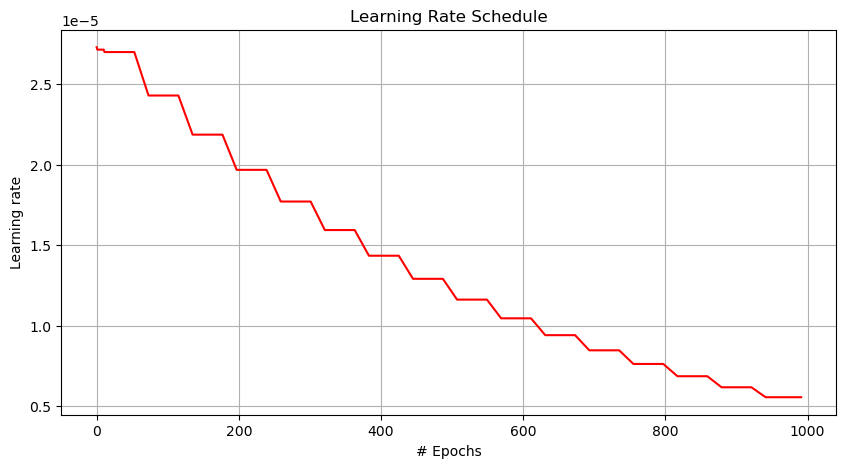

#### Baseline (Without Data Augmentation)

In [47]:
tBoard_log_dir.keys()

dict_keys(['resnet', 'resnet_noag', 'vgg', 'vgg_noag', 'mobilenet', 'mobilenet_noag', 'resnet_finetune', 'resnet_freeze', 'resnet_combined'])

In [48]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)


resnet_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_noag'], model_config = RESNET_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

resnet_noag_model, resnet_noag_train_loader, resnet_noag_test_loader, resnet_noag_data_augmentor, resnet_noag_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG_NO_AUGM, train_loader=train_loader, test_loader=test_loader, logger=resnet_noag_logger)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 15.09it/s]


 accuracy: 0.6696820175438597, eval_loss: 0.6102887326688097,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.90it/s]


accuracy: 0.9868421052631579, eval_loss: 0.06806514843105617, train_loss: 0.1829073280096054

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.71it/s]


accuracy: 0.9904057017543859, eval_loss: 0.04332733692258204, train_loss: 0.1485144942998886

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.42it/s]


accuracy: 0.9917763157894737, eval_loss: 0.0333339028523034, train_loss: 0.21437573432922363

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.09it/s]


accuracy: 0.9912280701754386, eval_loss: 0.03132637255271619, train_loss: 0.07928795367479324

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.36it/s]


accuracy: 0.9928728070175439, eval_loss: 0.02600258212228175, train_loss: 0.09228050708770752

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.89it/s]


accuracy: 0.9912280701754386, eval_loss: 0.029080167195755628, train_loss: 0.07745005935430527

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.62it/s]


accuracy: 0.9893092105263158, eval_loss: 0.032189929609446326, train_loss: 0.12736712396144867

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:13<00:00,  8.25it/s]


accuracy: 0.9917763157894737, eval_loss: 0.025114944863864303, train_loss: 0.04433850571513176

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.38it/s]


accuracy: 0.9901315789473685, eval_loss: 0.02839280467857239, train_loss: 0.07475578784942627

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.50it/s]


accuracy: 0.9901315789473685, eval_loss: 0.029997294466419702, train_loss: 0.01809416525065899

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.43it/s]


accuracy: 0.9923245614035088, eval_loss: 0.022691456553027883, train_loss: 0.04002752527594566

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.88it/s]


accuracy: 0.9920504385964912, eval_loss: 0.022259513611380385, train_loss: 0.08633720129728317

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:13<00:00,  8.19it/s]


accuracy: 0.9925986842105263, eval_loss: 0.02196952797729816, train_loss: 0.0490984283387661

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.23it/s]


accuracy: 0.993421052631579, eval_loss: 0.02110224177299084, train_loss: 0.1370784044265747

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.37it/s]


accuracy: 0.9920504385964912, eval_loss: 0.021406699450029952, train_loss: 0.04434268921613693

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.12it/s]

accuracy: 0.993421052631579, eval_loss: 0.020763281603362167, train_loss: 0.03683037310838699


#### Training with Data Augmentation

In [49]:

train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

resnet_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

resnet_model, resnet_train_loader, resnet_test_loader, resnet_data_augmentor, resnet_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader, logger = resnet_logger)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.26it/s]


 accuracy: 0.6757127192982456, eval_loss: 0.9132482086618742,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.09it/s]


accuracy: 0.9756030701754386, eval_loss: 0.12803277437750807, train_loss: 0.736618161201477

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.59it/s]


accuracy: 0.9682017543859649, eval_loss: 0.15781644427037814, train_loss: 0.30376702547073364

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00, 10.11it/s]


accuracy: 0.9761513157894737, eval_loss: 0.1509898812755158, train_loss: 0.4663355350494385

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.71it/s]


accuracy: 0.9750548245614035, eval_loss: 0.14721149000290193, train_loss: 0.3712955117225647

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.61it/s]


accuracy: 0.9739583333333334, eval_loss: 0.16966876364721542, train_loss: 0.6749858856201172

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.39it/s]


accuracy: 0.9750548245614035, eval_loss: 0.1631356440157744, train_loss: 0.5648346543312073

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.87it/s]


accuracy: 0.9871162280701754, eval_loss: 0.1252274836756681, train_loss: 0.5087283849716187

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.70it/s]


accuracy: 0.9786184210526315, eval_loss: 0.14814829087832518, train_loss: 0.7262400984764099

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.45it/s]


accuracy: 0.9879385964912281, eval_loss: 0.13330227479730783, train_loss: 0.7517620325088501

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.45it/s]


accuracy: 0.9882127192982456, eval_loss: 0.14663056548880904, train_loss: 0.671899676322937

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.16it/s]


accuracy: 0.9857456140350878, eval_loss: 0.13752951963167442, train_loss: 0.33334648609161377

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.38it/s]


accuracy: 0.9871162280701754, eval_loss: 0.13799465513020231, train_loss: 0.5259146690368652

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.21it/s]


accuracy: 0.9821820175438597, eval_loss: 0.16244503143325187, train_loss: 0.47920775413513184

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.38it/s]


accuracy: 0.9857456140350878, eval_loss: 0.1401280493132378, train_loss: 0.528621256351471

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.65it/s]


accuracy: 0.9835526315789473, eval_loss: 0.14905745052454764, train_loss: 0.4882082939147949

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.13it/s]

accuracy: 0.9887609649122807, eval_loss: 0.13853808891093522, train_loss: 0.44504421949386597


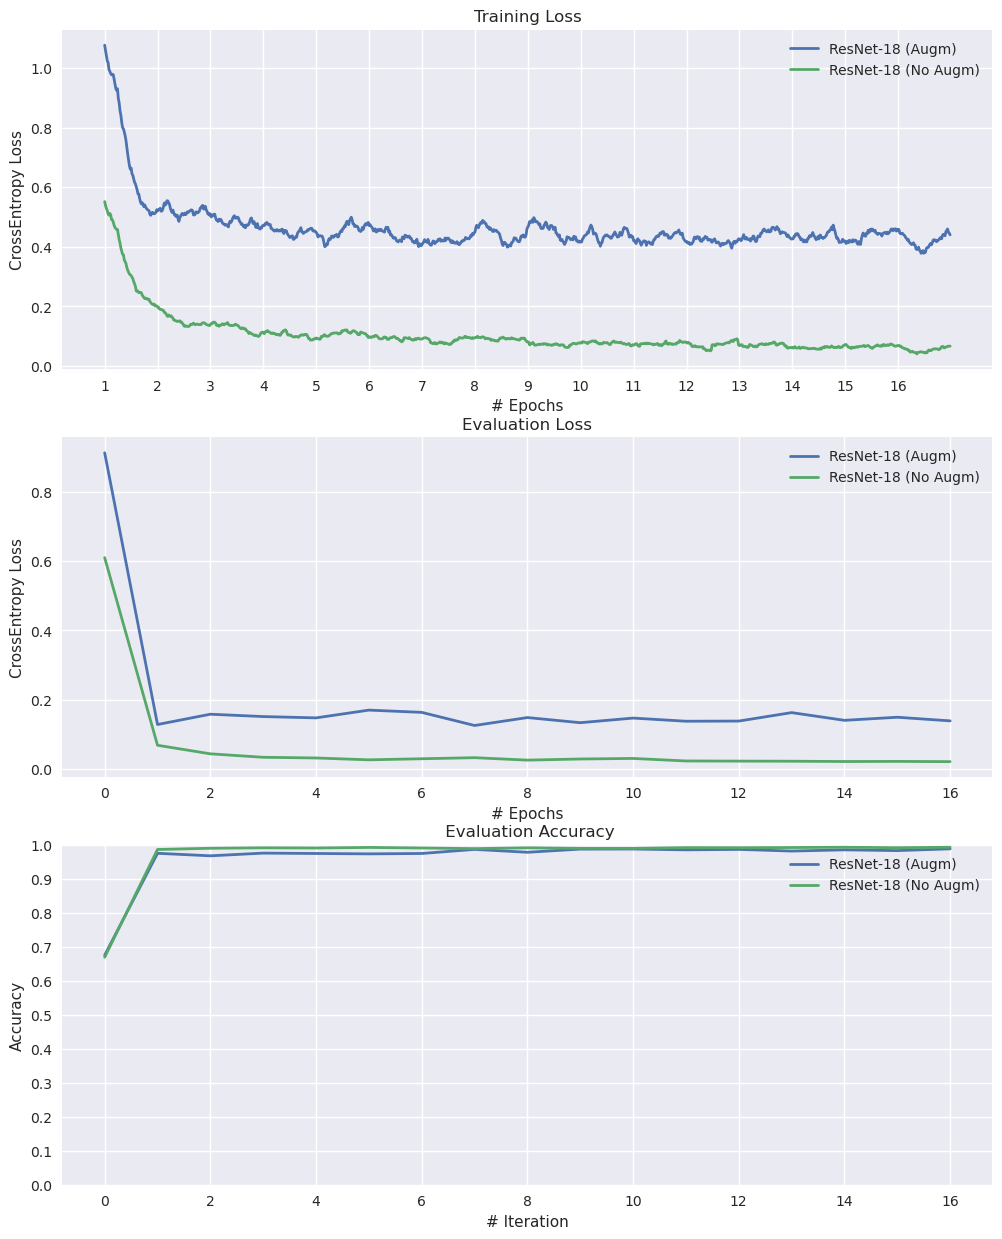

In [50]:
def compare_training_results(logger_list: list, model_names: list, config: dict):
    assert len(logger_list)==len(model_names), f'Length of logger list {len(logger_list)} does not correspond to the length of the mode list {len(model_names)}'
    #iteration_corrected = [np.sum(np.arange(i)*config['num_iterations']) for i in range(config['num_epochs']+1)]
    xticks = range(0, config['num_epochs']*config['num_iterations'], config['num_iterations'])
    plt.style.use('seaborn-v0_8')
    # Load the data from the MLP training
    data = []
    train_loss = []
    eval_loss = []
    eval_acc = []
    for logger in logger_list:
        data = logger.get_log()
        train_loss.append(data['train_loss'])
        eval_loss.append(data['eval_loss'])
        eval_acc.append(data['accuracy'])
    fig = plt.figure(figsize=(12,15))

    ax1 = fig.add_subplot(311)
    for i in range(len(logger_list)):
        smooth_loss = tg.visualization.smooth_curve(train_loss[i], 31)
        ax1.plot(smooth_loss, label=model_names[i], linewidth=2)

    ax1.set_xlabel("# Epochs")
    ax1.set_xticks(xticks, np.arange(1, config['num_epochs']+1))
    ax1.set_ylabel("CrossEntropy Loss")
    ax1.set_title('Training Loss')
    ax1.legend()

    ax2 = fig.add_subplot(312)
    for i in range(len(logger_list)):
        ax2.plot(eval_loss[i], label=model_names[i], linewidth=2)

    ax2.set_xlabel("# Epochs")
    ax2.set_ylabel("CrossEntropy Loss")
    ax2.set_title('Evaluation Loss')
    ax2.legend()

    ax3 = fig.add_subplot(313)
    for i in range(len(logger_list)):
        ax3.plot(eval_acc[i], label=model_names[i], linewidth=2)

    ax3.set_ylim(0.0,1.0)
    ax3.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax3.set_xlabel("# Iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_title(' Evaluation Accuracy')
    ax3.legend()

    return fig

fig = compare_training_results([resnet_logger, resnet_noag_logger], ['ResNet-18 (Augm)', 'ResNet-18 (No Augm)'], RESNET_MODEL_CONFIG)

### VGG-11

In [51]:
VGG_MODEL_ARCHITECTURE =     [
                                    {'type': 'VGG', 'size': 11, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 25088, 'out_features': 4608},
                                    {'type': 'batchnorm1d', 'num_features': 4608, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 4608, 'out_features': 256},
                                    {'type': 'batchnorm1d', 'num_features': 256, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 256, 'out_features': 2},
                                ]


VGG_MODEL_CONFIG =  {
                            'layers': VGG_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

VGG_MODEL_CONFIG_NO_AUGM =  {
                            'layers': VGG_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

#### Baseline (Without Data Augmentation)

In [52]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=VGG_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=VGG_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)

vgg_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['vgg_noag'], model_config = VGG_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

vgg_noag_model, vgg_noag_train_loader, vgg_noag_test_loader, vgg_noag_data_augmentor, vgg_noag_logger = tg.training.trainNN(config=VGG_MODEL_CONFIG_NO_AUGM, logger=vgg_noag_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.45it/s]


 accuracy: 0.6151315789473685, eval_loss: 0.6818001568317413,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.91it/s]


accuracy: 0.9695723684210527, eval_loss: 0.09895142202322747, train_loss: 0.12713421881198883

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:18<00:00,  6.21it/s]


accuracy: 0.9506578947368421, eval_loss: 0.13781131408994265, train_loss: 0.19807060062885284

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:19<00:00,  5.82it/s]


accuracy: 0.977796052631579, eval_loss: 0.08466442637635689, train_loss: 0.10584092885255814

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:18<00:00,  6.18it/s]


accuracy: 0.9750548245614035, eval_loss: 0.0648838457867928, train_loss: 0.08908732235431671

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.48it/s]


accuracy: 0.981359649122807, eval_loss: 0.06558226853846, train_loss: 0.12664943933486938

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.34it/s]


accuracy: 0.9851973684210527, eval_loss: 0.060044587918622584, train_loss: 0.28132155537605286

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.78it/s]


accuracy: 0.9857456140350878, eval_loss: 0.059000554751898894, train_loss: 0.13819652795791626

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.87it/s]


accuracy: 0.984375, eval_loss: 0.0531307536651168, train_loss: 0.05279720202088356

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.12it/s]


accuracy: 0.9838267543859649, eval_loss: 0.05484651339550813, train_loss: 0.03470857813954353

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.42it/s]


accuracy: 0.987390350877193, eval_loss: 0.04361005575526832, train_loss: 0.08297785371541977

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.45it/s]


accuracy: 0.9783442982456141, eval_loss: 0.07376810113425579, train_loss: 0.08469744026660919

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.85it/s]


accuracy: 0.9865679824561403, eval_loss: 0.04104165783102967, train_loss: 0.09833146631717682

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.03it/s]


accuracy: 0.9851973684210527, eval_loss: 0.0492612888440163, train_loss: 0.1435839980840683

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.02it/s]


accuracy: 0.9821820175438597, eval_loss: 0.058721392307218095, train_loss: 0.05380622670054436

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.58it/s]


accuracy: 0.9849232456140351, eval_loss: 0.04864376913265962, train_loss: 0.056276027113199234

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.39it/s]

accuracy: 0.9841008771929824, eval_loss: 0.060164567203620414, train_loss: 0.15076377987861633


#### Training with Data Augmentation

In [53]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=VGG_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=VGG_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

vgg_logger = tg.logging.Logger(save_dir=tBoard_log_dir['vgg'], model_config = VGG_MODEL_CONFIG, save_external=True, save_internal=True)

vgg_model, vgg_train_loader, vgg_test_loader, vgg_data_augmentor, vgg_logger = tg.training.trainNN(config=VGG_MODEL_CONFIG, logger=vgg_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.37it/s]


 accuracy: 0.3736293859649123, eval_loss: 0.7429491495876982,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.46it/s]


accuracy: 0.924890350877193, eval_loss: 0.20292198719260723, train_loss: 0.3539852797985077

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.71it/s]


accuracy: 0.9577850877192983, eval_loss: 0.14862062113580146, train_loss: 0.4843955636024475

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.73it/s]


accuracy: 0.9816337719298246, eval_loss: 0.10096258117833681, train_loss: 0.6461556553840637

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.72it/s]


accuracy: 0.9816337719298246, eval_loss: 0.11406858255596537, train_loss: 0.4332582354545593

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.56it/s]


accuracy: 0.9810855263157895, eval_loss: 0.12578458564454004, train_loss: 0.5988377928733826

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  7.63it/s]


accuracy: 0.9827302631578947, eval_loss: 0.1128832584230654, train_loss: 0.42999905347824097

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:17<00:00,  6.69it/s]


accuracy: 0.9857456140350878, eval_loss: 0.10962708645679972, train_loss: 0.4759657382965088

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.79it/s]


accuracy: 0.9860197368421053, eval_loss: 0.1046278126080308, train_loss: 0.42601656913757324

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  7.04it/s]


accuracy: 0.9879385964912281, eval_loss: 0.10580282838067465, train_loss: 0.3050360679626465

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.56it/s]


accuracy: 0.9857456140350878, eval_loss: 0.10132662718298666, train_loss: 0.515288233757019

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.44it/s]


accuracy: 0.984375, eval_loss: 0.11304235713262308, train_loss: 0.5852107405662537

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.80it/s]


accuracy: 0.9854714912280702, eval_loss: 0.1216952256335501, train_loss: 0.4661889374256134

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.92it/s]


accuracy: 0.9816337719298246, eval_loss: 0.12375061155149811, train_loss: 0.270513117313385

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.40it/s]


accuracy: 0.9851973684210527, eval_loss: 0.11983346475059525, train_loss: 0.26455003023147583

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:15<00:00,  7.48it/s]


accuracy: 0.9832785087719298, eval_loss: 0.12853555845325454, train_loss: 0.22608831524848938

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:16<00:00,  6.95it/s]


accuracy: 0.9893092105263158, eval_loss: 0.10297982744349722, train_loss: 0.5315949320793152


### MobileNet-V3

In [54]:
MOBILENET_MODEL_ARCHITECTURE =     [
                                    {'type': 'MobileNetV3', 'size': 'small', 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 576, 'out_features': 2}
                                ]



MOBILENET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

MOBILENET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

#### Baseline (Without Data Augmentation)

In [56]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG_NO_AUGM['batch_size'], shuffle=False, drop_last=True)

mbnet_noag_logger = tg.logging.Logger(save_dir=tBoard_log_dir['mobilenet_noag'], model_config = MOBILENET_MODEL_CONFIG_NO_AUGM, save_external=True, save_internal=True)

mbnet_noag_model, mbnet_noag_train_loader, mbnet_noag_test_loader, mbnet_noag_data_augmentor, mbnet_noag_logger = tg.training.trainNN(config=MOBILENET_MODEL_CONFIG_NO_AUGM, logger=mbnet_noag_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 15.67it/s]


 accuracy: 0.7393092105263158, eval_loss: 0.534111291692968,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 15.13it/s]


accuracy: 0.9879385964912281, eval_loss: 0.05872303150439014, train_loss: 0.131203293800354

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.36it/s]


accuracy: 0.9904057017543859, eval_loss: 0.03757308561532562, train_loss: 0.13076025247573853

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.36it/s]


accuracy: 0.9904057017543859, eval_loss: 0.03713624451611714, train_loss: 0.13934500515460968

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.19it/s]


accuracy: 0.9923245614035088, eval_loss: 0.027472149541401387, train_loss: 0.054088134318590164

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.62it/s]


accuracy: 0.990953947368421, eval_loss: 0.031033390547810614, train_loss: 0.05200697481632233

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.25it/s]


accuracy: 0.9923245614035088, eval_loss: 0.024477901844524273, train_loss: 0.037003930658102036

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.02it/s]


accuracy: 0.990953947368421, eval_loss: 0.027915750859711694, train_loss: 0.03523406758904457

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.62it/s]


accuracy: 0.990953947368421, eval_loss: 0.025761414256984402, train_loss: 0.047479432076215744

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.64it/s]


accuracy: 0.9928728070175439, eval_loss: 0.024104150603402798, train_loss: 0.04492941126227379

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.80it/s]


accuracy: 0.9912280701754386, eval_loss: 0.027951739149310078, train_loss: 0.03620576858520508

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.87it/s]


accuracy: 0.9928728070175439, eval_loss: 0.021643709222221412, train_loss: 0.09432481229305267

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.63it/s]


accuracy: 0.9925986842105263, eval_loss: 0.021855696944010305, train_loss: 0.03711437061429024

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.24it/s]


accuracy: 0.9928728070175439, eval_loss: 0.021550712970406095, train_loss: 0.11280890554189682

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.76it/s]


accuracy: 0.9915021929824561, eval_loss: 0.022101661923602876, train_loss: 0.03130347281694412

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.51it/s]


accuracy: 0.9904057017543859, eval_loss: 0.022645526829460562, train_loss: 0.024837080389261246

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.28it/s]

accuracy: 0.9931469298245614, eval_loss: 0.020916282395008142, train_loss: 0.009349577128887177


#### Training with Data Augmentation

In [57]:
train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=MOBILENET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

mbnet_logger = tg.logging.Logger(save_dir=tBoard_log_dir['mobilenet'], model_config = MOBILENET_MODEL_CONFIG, save_external=True, save_internal=True)

mbnet_model, mbnet_train_loader, mbnet_test_loader, mbnet_data_augmentor, mbnet_logger = tg.training.trainNN(config=MOBILENET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.30it/s]


 accuracy: 0.543859649122807, eval_loss: 0.7060880600883249,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


accuracy: 0.9734100877192983, eval_loss: 0.16484469948173092, train_loss: 0.34960687160491943

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.31it/s]


accuracy: 0.9797149122807017, eval_loss: 0.1541541948130256, train_loss: 0.5571725368499756

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


accuracy: 0.9862938596491229, eval_loss: 0.14750621428615168, train_loss: 0.5632315874099731

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:14<00:00,  7.81it/s]


accuracy: 0.9865679824561403, eval_loss: 0.14448825116350986, train_loss: 0.435641348361969

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.61it/s]


accuracy: 0.9862938596491229, eval_loss: 0.15173222075559592, train_loss: 0.33541736006736755

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.82it/s]


accuracy: 0.9876644736842105, eval_loss: 0.14204219160111328, train_loss: 0.32759734988212585

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:13<00:00,  8.45it/s]


accuracy: 0.9882127192982456, eval_loss: 0.14939786519920617, train_loss: 0.24655233323574066

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.42it/s]


accuracy: 0.9879385964912281, eval_loss: 0.14127473137749916, train_loss: 0.3945693373680115

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.78it/s]


accuracy: 0.9849232456140351, eval_loss: 0.17118675349966475, train_loss: 0.30473077297210693

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.18it/s]


accuracy: 0.9805372807017544, eval_loss: 0.1772521442750044, train_loss: 0.20215575397014618

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.45it/s]


accuracy: 0.9893092105263158, eval_loss: 0.14218952487173833, train_loss: 0.3003481328487396

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.17it/s]


accuracy: 0.9841008771929824, eval_loss: 0.1589137581095361, train_loss: 0.6521732211112976

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.47it/s]


accuracy: 0.9862938596491229, eval_loss: 0.14672265414213925, train_loss: 0.5485697984695435

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.76it/s]


accuracy: 0.9841008771929824, eval_loss: 0.16087008444102188, train_loss: 0.44011545181274414

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.26it/s]


accuracy: 0.984375, eval_loss: 0.15971693801775314, train_loss: 0.30444809794425964

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.50it/s]

accuracy: 0.9799890350877193, eval_loss: 0.16521328380494787, train_loss: 0.4348510503768921


### Evaluation

We trained models with different feature extractors as their backbones. Namely, we chose the "ResNet-18", "VGG-11" and "MobileNetV3-Small". We took all networks in the smallest configuration to keep it comparable. Overall, we noticed that all models perform well on the tasks with an accuracy of ~98% even without any elaborated data augmentation (shown in "Model Comparison"). Here we have to note that even the models trained without data augmentation still use randomly cropped images in the training set which possibly improves their performance. Since we already have a high accuracy, we would refrain from further advanced data augmentation techniques for our task. Still, since we were explicitely asked to do so, we use the data augmentation techniques as described in section "Data Augmentation" and evaluate the models.

#### Training Progress

The models trained with the data augmentation technique perform simlarily well an achieve an accuracy of ~98% on the test dataset. The training progress starts stagnating after 6 epochs and one could think about early-stopping. Due to the data augmentation the training loss is higher than the evaluation loss. Applying MixUp, Color Jitter etc. makes the task more difficult and the models performs worse on the training set. Still, the model performs good on the test set. We conclude that the model is able to learn features in the training set transferable to the test set in order to determine if the image shows a dog or a cat.

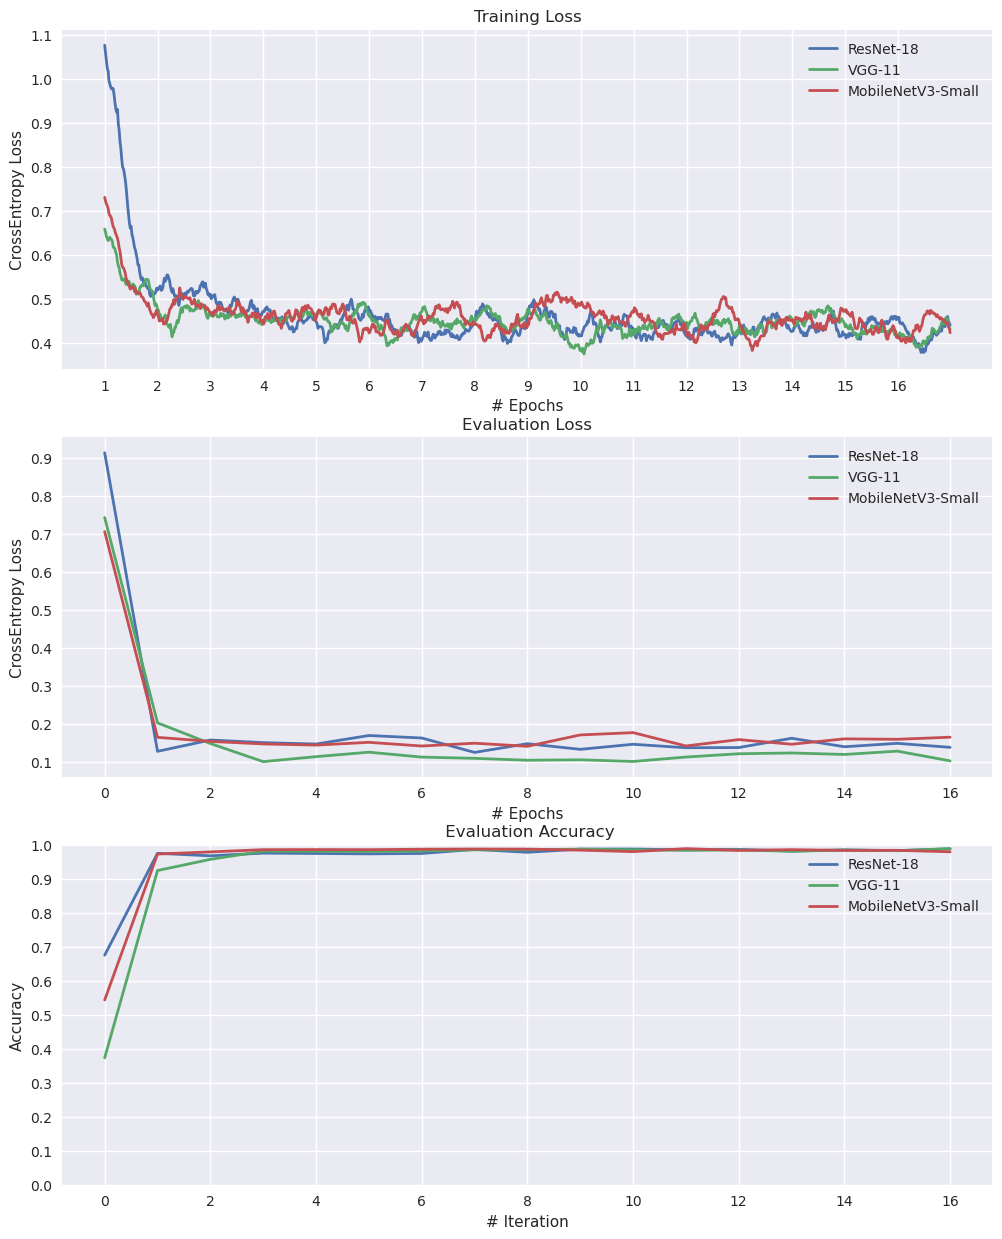

In [61]:
logger_list = [resnet_logger, vgg_logger, mbnet_logger]
names = ['ResNet-18', 'VGG-11', 'MobileNetV3-Small']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

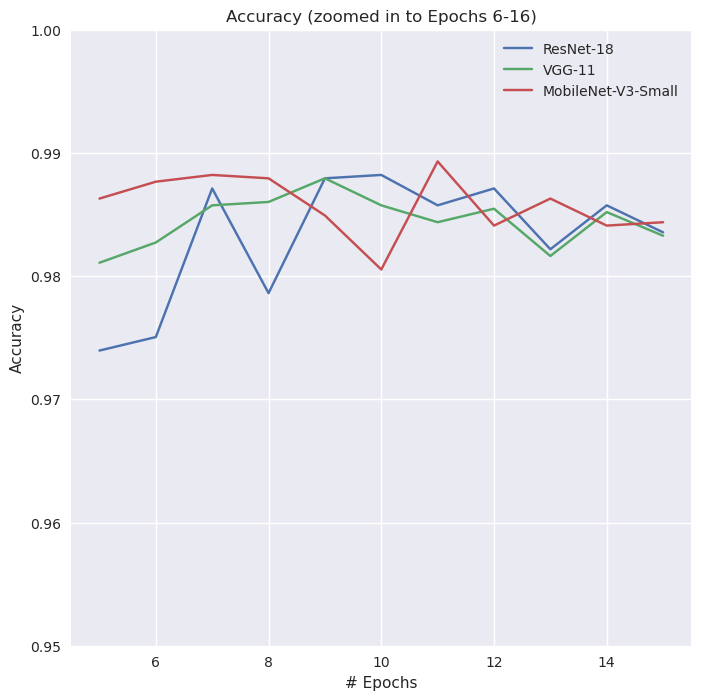

In [81]:
resnet_acc = resnet_logger.get_log()['accuracy']

vgg_acc = vgg_logger.get_log()['accuracy']

mobilenet_acc = mbnet_logger.get_log()['accuracy']


plot_data = [resnet_acc, vgg_acc, mobilenet_acc]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['ResNet-18', 'VGG-11', 'MobileNet-V3-Small']

fig, ax = plt.subplots(1, 1,figsize=(8,8))

for i, d in enumerate(plot_data):
    ax.plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax.set_title('Accuracy (zoomed in to Epochs 6-16)')
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.95, 1.0)
ax.legend()


#### Model Comparison

The final results, show that the data augmentation techniques did not improve the initially very good models. Overall we can say the the MobileNetV3 performed best.

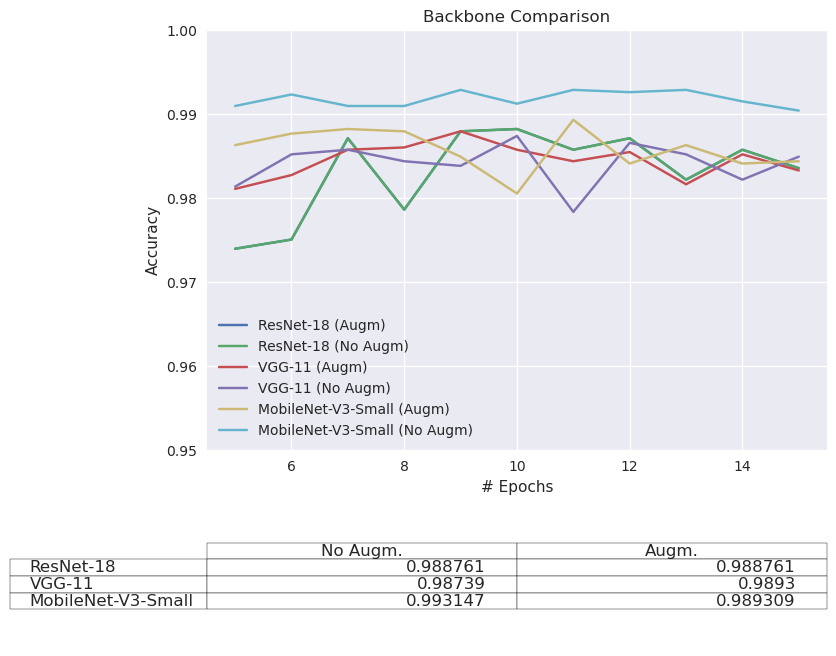

In [78]:


resnet_acc = resnet_logger.get_log()['accuracy']

resnet_noag_acc = resnet_logger.get_log()['accuracy']

vgg_acc = vgg_logger.get_log()['accuracy']

vgg_noag_acc = vgg_noag_logger.get_log()['accuracy']

mobilenet_acc = mbnet_logger.get_log()['accuracy']

mobilenet_noag_acc = mbnet_noag_logger.get_log()['accuracy']

plot_data = [resnet_acc, resnet_noag_acc, vgg_acc, vgg_noag_acc, mobilenet_acc, mobilenet_noag_acc]


table_data = [[round(max(resnet_noag_acc), 6) , round(max(resnet_acc), 6)], 
        [round(max(vgg_noag_acc), 6), round(max(vgg_acc), 4)], 
        [round(max(mobilenet_noag_acc), 6), round(max(mobilenet_acc), 6)]]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['ResNet-18 (Augm)', 'ResNet-18 (No Augm)', 'VGG-11 (Augm)', 'VGG-11 (No Augm)', 'MobileNet-V3-Small (Augm)', 'MobileNet-V3-Small (No Augm)']

fig, ax = plt.subplots(2, 1,figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]})

for i, d in enumerate(plot_data):
    ax[0].plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax[0].set_title('Backbone Comparison')
ax[0].set_xlabel('# Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.95, 1.0)
ax[0].legend()

table = ax[1].table(cellText=table_data, rowLabels=['ResNet-18', 'VGG-11', 'MobileNet-V3-Small'], colLabels = ['No Augm.', 'Augm.'], loc='center')
ax[1].axis('off')
# Set the font size
table.auto_set_font_size(False)
table.set_fontsize(12)
fig.show()

#### Data Augmentation
Here we show the training progress for the models with and without data augmentation exemplarily for the MobileNetV3. We can see that the data augmentation makes the training dataset significantly harder. The loss on the training dataset with data augmentations is significantly higher. The data augmentation seems to not improve the performance.

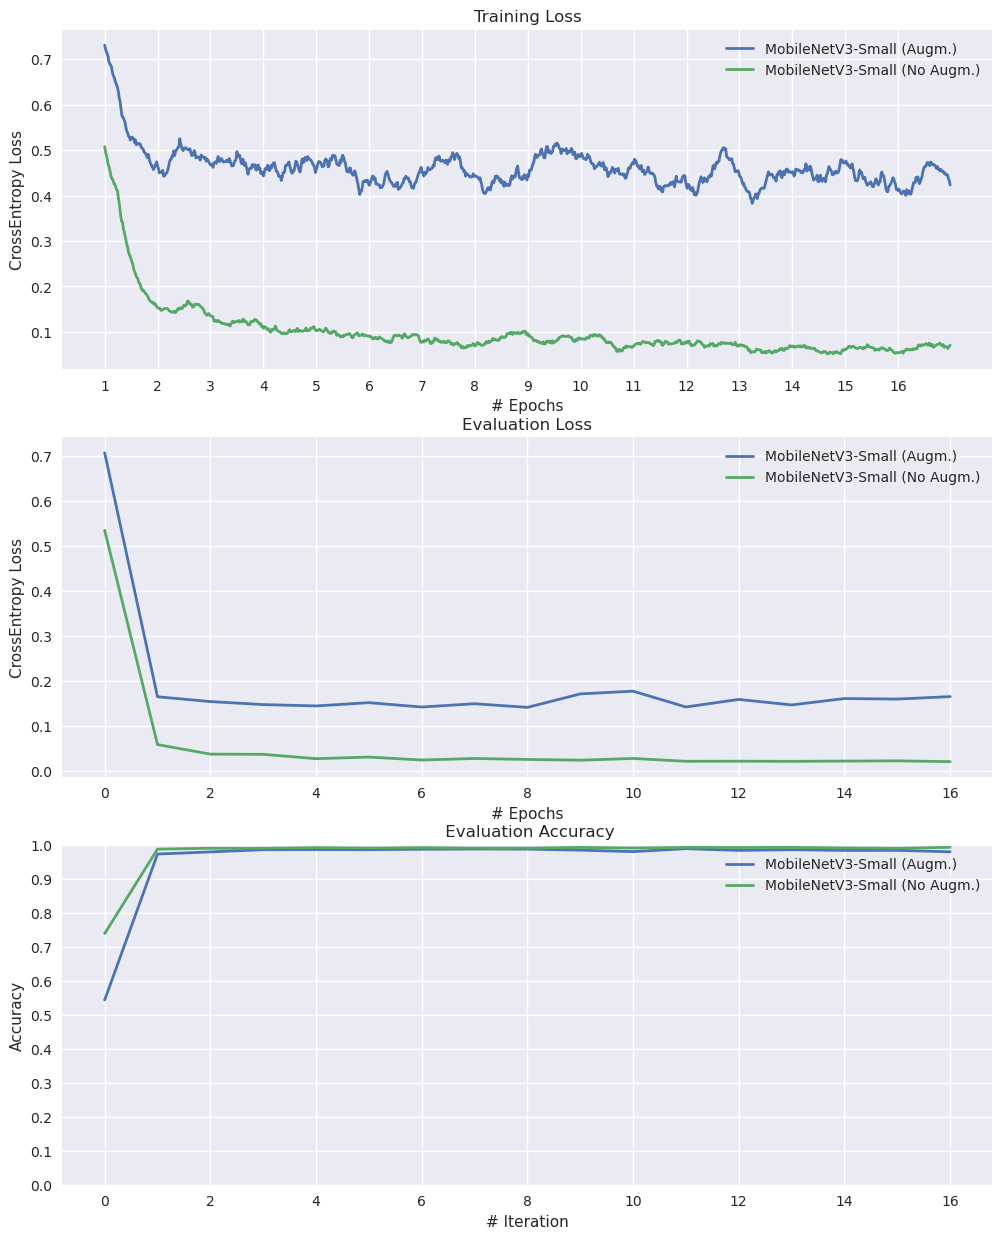

In [60]:
logger_list = [mbnet_logger, mbnet_noag_logger]
names = ['MobileNetV3-Small (Augm.)', 'MobileNetV3-Small (No Augm.)']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

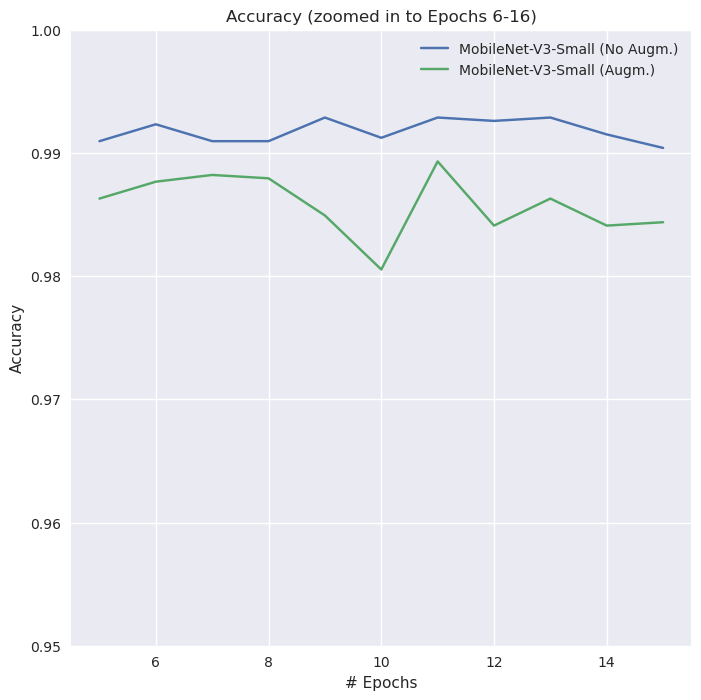

In [83]:


mobilenet_acc = mbnet_logger.get_log()['accuracy']
mobilenet_noag_acc = mbnet_noag_logger.get_log()['accuracy']



plot_data = [mobilenet_noag_acc, mobilenet_acc]

zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)
labels = ['MobileNet-V3-Small (No Augm.)', 'MobileNet-V3-Small (Augm.)']

fig, ax = plt.subplots(1, 1,figsize=(8,8))

for i, d in enumerate(plot_data):
    ax.plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax.set_title('Accuracy (zoomed in to Epochs 6-16)')
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.95, 1.0)
ax.legend()

## Task 2: ResNet Training Experiments

In [89]:

EXP_EPOCHS = 16


data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.4, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 2}
                                ]


RESNET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG)

RESNET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG_NO_AUGM['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG_NO_AUGM)



In [90]:

train_loader = torch.utils.data.DataLoader(train_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_augmentation_dataset, batch_size=RESNET_MODEL_CONFIG['batch_size'], shuffle=False, drop_last=True)

### ResNet-18 Fine-Tuned Model

In [91]:
finetuned_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_finetune'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)


finetuned_model, finetuned_train_loader, finetuned_test_loader, finetuned_data_augmentor, finetuned_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, logger=finetuned_logger, train_loader=train_loader, test_loader=test_loader)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 15.99it/s]


 accuracy: 0.5370065789473685, eval_loss: 0.707397171802688,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:07<00:00, 14.53it/s]


accuracy: 0.9572368421052632, eval_loss: 0.1915046282831514, train_loss: 0.6324577927589417

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.54it/s]


accuracy: 0.9739583333333334, eval_loss: 0.15532700746859374, train_loss: 0.3446906805038452

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


accuracy: 0.9660087719298246, eval_loss: 0.20079511868064864, train_loss: 0.42173635959625244

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.97it/s]


accuracy: 0.9819078947368421, eval_loss: 0.16942537821045048, train_loss: 0.4414747953414917

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.01it/s]


accuracy: 0.9832785087719298, eval_loss: 0.14695371203778082, train_loss: 0.2636583149433136

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.20it/s]


accuracy: 0.9849232456140351, eval_loss: 0.15506634619413762, train_loss: 0.6454189419746399

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.75it/s]


accuracy: 0.9821820175438597, eval_loss: 0.16282287958944053, train_loss: 0.7459942102432251

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.44it/s]


accuracy: 0.9871162280701754, eval_loss: 0.14310799669801144, train_loss: 0.30361446738243103

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.51it/s]


accuracy: 0.9786184210526315, eval_loss: 0.16471511177849352, train_loss: 0.29370182752609253

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.38it/s]


accuracy: 0.9868421052631579, eval_loss: 0.15708220351422042, train_loss: 0.5372251272201538

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.95it/s]


accuracy: 0.9862938596491229, eval_loss: 0.15122151139535403, train_loss: 0.42364415526390076

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.46it/s]


accuracy: 0.987390350877193, eval_loss: 0.1472013452204696, train_loss: 0.4638298451900482

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.94it/s]


accuracy: 0.9865679824561403, eval_loss: 0.15940527572182187, train_loss: 0.38222751021385193

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.64it/s]


accuracy: 0.9860197368421053, eval_loss: 0.13997833744475716, train_loss: 0.3673158288002014

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 13.10it/s]


accuracy: 0.9862938596491229, eval_loss: 0.1445542716731628, train_loss: 0.1841343492269516

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.81it/s]

accuracy: 0.9824561403508771, eval_loss: 0.15513777190394568, train_loss: 0.5067394971847534


### ResNet-18 Fixed Model

In [92]:
freeze_model = tg.models.NeuralNetwork(RESNET_MODEL_CONFIG['layers'])
freeze_model.freeze_backbone_model()

freeze_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_freeze'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

freeze_model, freeze_train_loader, freeze_test_loader, freeze_data_augmentor, freeze_logger = tg.training.trainNN(config=RESNET_MODEL_CONFIG, train_loader=train_loader, test_loader=test_loader)


Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.72it/s]


 accuracy: 0.35964912280701755, eval_loss: 1.1045088612458163,

Epoch 1/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.57it/s]


accuracy: 0.9618969298245614, eval_loss: 0.1813905636469523, train_loss: 0.7761197090148926

Epoch 2/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.27it/s]


accuracy: 0.9824561403508771, eval_loss: 0.157376855905903, train_loss: 0.5140858888626099

Epoch 3/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.46it/s]


accuracy: 0.9791666666666666, eval_loss: 0.16303781201049947, train_loss: 0.612553596496582

Epoch 4/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.70it/s]


accuracy: 0.9821820175438597, eval_loss: 0.15632173487622486, train_loss: 0.41778719425201416

Epoch 5/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.69it/s]


accuracy: 0.9846491228070176, eval_loss: 0.15140512628121333, train_loss: 0.630673885345459

Epoch 6/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.62it/s]


accuracy: 0.9854714912280702, eval_loss: 0.1354550461431867, train_loss: 0.3760005831718445

Epoch 7/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.79it/s]


accuracy: 0.9835526315789473, eval_loss: 0.1535924415577922, train_loss: 0.7528377175331116

Epoch 8/16


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.07it/s]


accuracy: 0.9810855263157895, eval_loss: 0.17497646086440796, train_loss: 0.6298485398292542

Epoch 9/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.06it/s]


accuracy: 0.9783442982456141, eval_loss: 0.17016414677103361, train_loss: 0.4458070695400238

Epoch 10/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.80it/s]


accuracy: 0.9794407894736842, eval_loss: 0.1593498424545192, train_loss: 0.42311760783195496

Epoch 11/16


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.81it/s]


accuracy: 0.9871162280701754, eval_loss: 0.15130856819450855, train_loss: 0.49962425231933594

Epoch 12/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.74it/s]


accuracy: 0.9846491228070176, eval_loss: 0.14446575625946648, train_loss: 0.24385353922843933

Epoch 13/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.10it/s]


accuracy: 0.9846491228070176, eval_loss: 0.14880182231335262, train_loss: 0.24896281957626343

Epoch 14/16


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.41it/s]


accuracy: 0.9819078947368421, eval_loss: 0.16780528478455126, train_loss: 0.6678534150123596

Epoch 15/16


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.76it/s]


accuracy: 0.9827302631578947, eval_loss: 0.15464542923789276, train_loss: 0.23609201610088348

Epoch 16/16


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.36it/s]


accuracy: 0.9772478070175439, eval_loss: 0.1716087075571219, train_loss: 0.583047091960907


### ResNet-18 Combined Model

In [93]:
combined_model = tg.models.NeuralNetwork(RESNET_MODEL_CONFIG['layers'])
combined_model.freeze_backbone_model()

combined_config = copy.deepcopy(RESNET_MODEL_CONFIG)
combined_config['num_epochs'] = int(combined_config['num_epochs'] / 2)

combined_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_combined'], model_config = RESNET_MODEL_CONFIG, save_external=True, save_internal=True)

combined_model, combined_train_loader, combined_test_loader, combined_data_augmentor, combined_logger = tg.training.trainNN(config=combined_config, logger=combined_logger, train_loader=train_loader, test_loader=test_loader)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.44it/s]


 accuracy: 0.715734649122807, eval_loss: 0.581502929591296,

Epoch 1/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.86it/s]


accuracy: 0.9714912280701754, eval_loss: 0.16451766080500788, train_loss: 0.6541711091995239

Epoch 2/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.49it/s]


accuracy: 0.9605263157894737, eval_loss: 0.1858715111749214, train_loss: 0.38304781913757324

Epoch 3/8


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


accuracy: 0.9824561403508771, eval_loss: 0.15916537771230205, train_loss: 0.46665769815444946

Epoch 4/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.36it/s]


accuracy: 0.9791666666666666, eval_loss: 0.1633276024408508, train_loss: 0.5464615821838379

Epoch 5/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.82it/s]


accuracy: 0.9824561403508771, eval_loss: 0.15427459060753645, train_loss: 0.5168979167938232

Epoch 6/8


Evaluation:: 100%|██████████| 114/114 [00:12<00:00,  9.34it/s]


accuracy: 0.984375, eval_loss: 0.1504598372011331, train_loss: 0.6150550842285156

Epoch 7/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.79it/s]


accuracy: 0.9819078947368421, eval_loss: 0.1707732602627131, train_loss: 0.47749218344688416

Epoch 8/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 11.49it/s]

accuracy: 0.981359649122807, eval_loss: 0.16334342989220954, train_loss: 0.2975463271141052


In [94]:
combined_model.unfreeze_backbone_model()

combined_config['learning_rate'] *= 0.1
combined_model, combined_train_loader, combined_test_loader, combined_data_augmentor, combined_logger = tg.training.trainNN(config=combined_config,
                                                                                                                            model=combined_model,
                                                                                                                            train_loader=combined_train_loader,
                                                                                                                            test_loader=combined_test_loader,
                                                                                                                            data_augmentor=combined_data_augmentor,
                                                                                                                            logger = combined_logger)

Initial Evluation


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.77it/s]


 accuracy: 0.981359649122807, eval_loss: 0.16334342989220954, train_loss: 0.2975463271141052,

Epoch 1/8


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.02it/s]


accuracy: 0.9772478070175439, eval_loss: 0.17926670411568985, train_loss: 0.5528824329376221

Epoch 2/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.30it/s]


accuracy: 0.9854714912280702, eval_loss: 0.1513842483819054, train_loss: 0.29527294635772705

Epoch 3/8


Evaluation:: 100%|██████████| 114/114 [00:08<00:00, 12.78it/s]


accuracy: 0.9851973684210527, eval_loss: 0.15033766241711483, train_loss: 0.6699454188346863

Epoch 4/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.79it/s]


accuracy: 0.9846491228070176, eval_loss: 0.15027043376967572, train_loss: 0.2605251967906952

Epoch 5/8


Evaluation:: 100%|██████████| 114/114 [00:11<00:00,  9.84it/s]


accuracy: 0.984375, eval_loss: 0.14496229654341414, train_loss: 0.6321386098861694

Epoch 6/8


Evaluation:: 100%|██████████| 114/114 [00:10<00:00, 11.28it/s]


accuracy: 0.9747807017543859, eval_loss: 0.17076509909933074, train_loss: 0.5615063905715942

Epoch 7/8


Evaluation:: 100%|██████████| 114/114 [00:13<00:00,  8.74it/s]


accuracy: 0.9832785087719298, eval_loss: 0.15180684397356553, train_loss: 0.49418357014656067

Epoch 8/8


Evaluation:: 100%|██████████| 114/114 [00:09<00:00, 12.00it/s]

accuracy: 0.9830043859649122, eval_loss: 0.15317910589408457, train_loss: 0.4029090404510498


### Evaluation

All models perform similarily well and achieve an accuracy of ~98%. All models despite the backbone being not being trained seem to learn the task in the same manner. In the combined model the training technique is switched after the model already converge to a local minmum such that including the backbone in the training pipeline does not have a big effect.

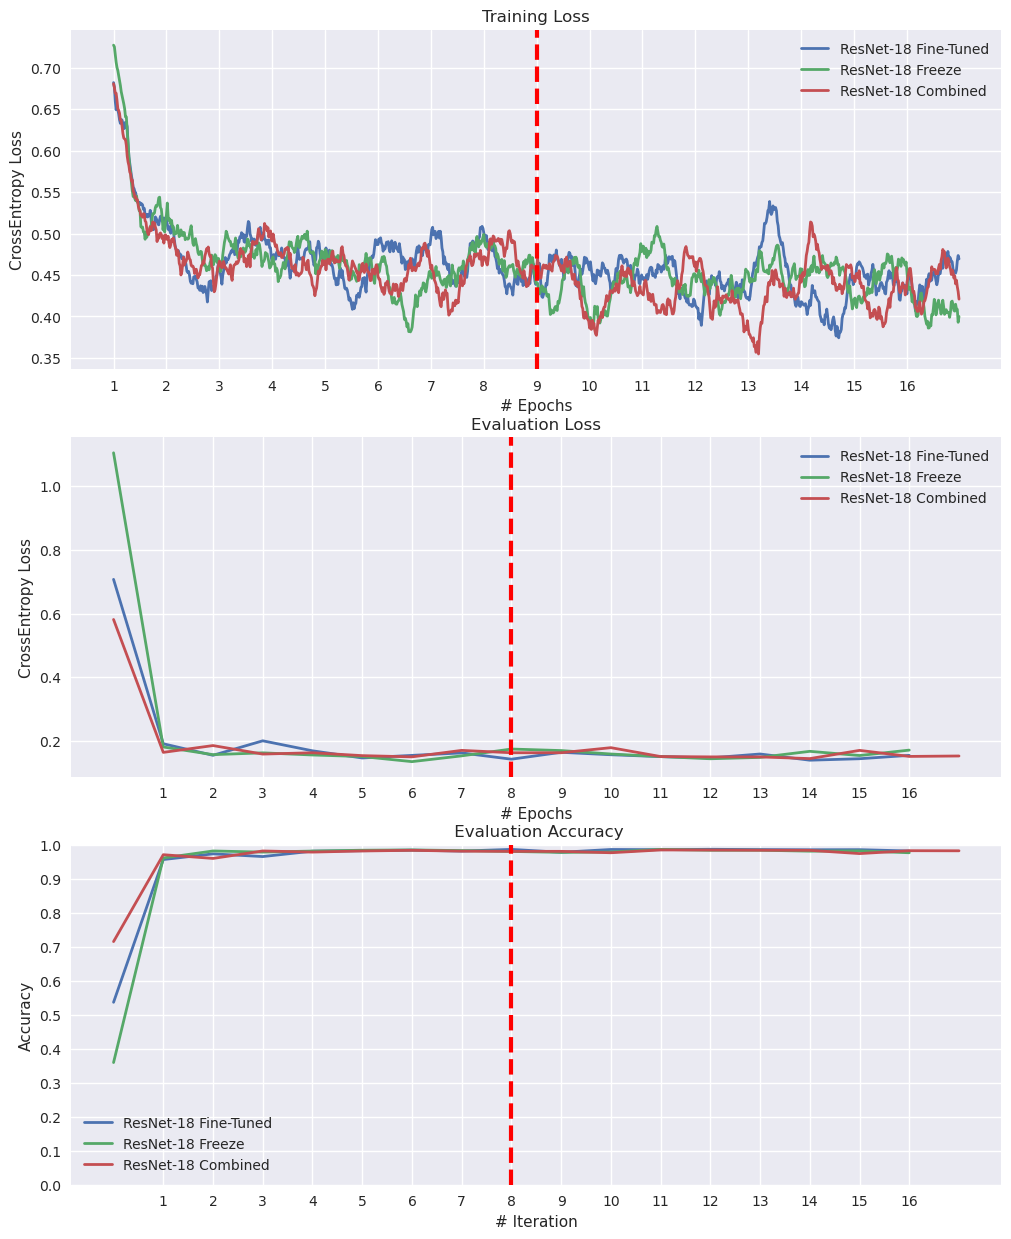

In [98]:
def compare_training_results(logger_list: list, model_names: list, config: dict):
    assert len(logger_list)==len(model_names), f'Length of logger list {len(logger_list)} does not correspond to the length of the mode list {len(model_names)}'
    #iteration_corrected = [np.sum(np.arange(i)*config['num_iterations']) for i in range(config['num_epochs']+1)]
    xticks = range(0, config['num_epochs']*config['num_iterations'], config['num_iterations'])
    plt.style.use('seaborn-v0_8')
    # Load the data from the MLP training
    data = []
    train_loss = []
    eval_loss = []
    eval_acc = []
    for logger in logger_list:
        data = logger.get_log()
        train_loss.append(data['train_loss'])
        eval_loss.append(data['eval_loss'])
        eval_acc.append(data['accuracy'])
    fig = plt.figure(figsize=(12,15))

    ax1 = fig.add_subplot(311)
    for i in range(len(logger_list)):
        smooth_loss = tg.visualization.smooth_curve(train_loss[i], 31)
        ax1.plot(smooth_loss, label=model_names[i], linewidth=2)

    ax1.set_xlabel("# Epochs")
    ax1.set_xticks(xticks, np.arange(1, config['num_epochs']+1))
    ax1.set_ylabel("CrossEntropy Loss")
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.axvline(x=8*config['num_iterations'], color="red", ls="--", linewidth=3)


    ax2 = fig.add_subplot(312)
    for i in range(len(logger_list)):
        ax2.plot(eval_loss[i], label=model_names[i], linewidth=2)

    ax2.set_xlabel("# Epochs")
    ax2.set_ylabel("CrossEntropy Loss")
    ax2.set_title('Evaluation Loss')
    ax2.set_xticks(np.arange(1, config['num_epochs']+1))
    ax2.legend()
    ax2.axvline(x=8, color="red", ls="--", linewidth=3)


    ax3 = fig.add_subplot(313)
    for i in range(len(logger_list)):
        ax3.plot(eval_acc[i], label=model_names[i], linewidth=2)

    ax3.set_ylim(0.0,1.0)
    ax3.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax3.set_xlabel("# Iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_xticks(np.arange(1, config['num_epochs']+1))
    ax3.set_title(' Evaluation Accuracy')
    ax3.legend()
    ax3.axvline(x=8, color="red", ls="--", linewidth=3)



logger_list = [finetuned_logger, freeze_logger, combined_logger]
names = ['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined']

compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)

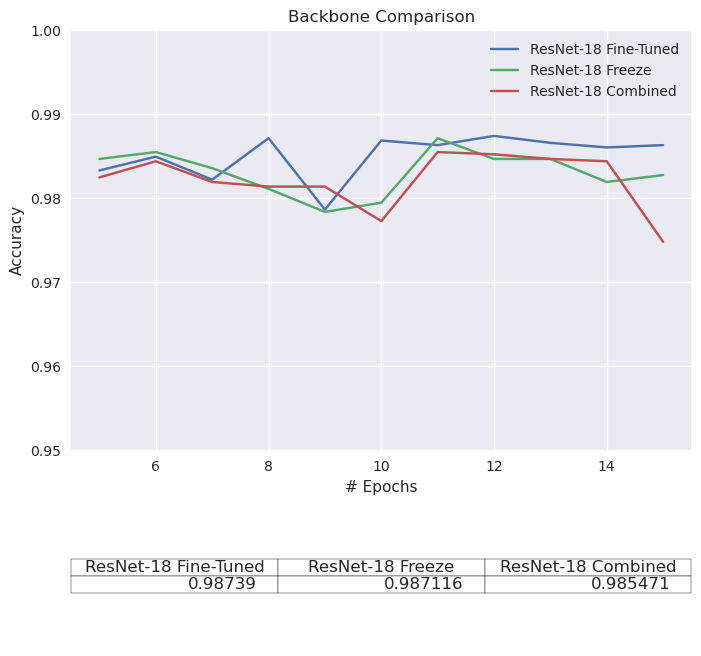

In [103]:

fine_tuned_acc = finetuned_logger.get_log()['accuracy']
freeze_acc = freeze_logger.get_log()['accuracy']
combined_acc = combined_logger.get_log()['accuracy']


plot_data = [fine_tuned_acc, freeze_acc, combined_acc]


labels = ['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined']

table_data = [[round(max(fine_tuned_acc), 6) , round(max(freeze_acc), 6), round(max(combined_acc), 6)]]
zoom_range = (5,16)
x = np.arange(zoom_range[0], zoom_range[1], 1)

fig, ax = plt.subplots(2, 1,figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]})

for i, d in enumerate(plot_data):
    ax[0].plot(x, d[zoom_range[0]:zoom_range[1]], label=labels[i])

ax[0].set_title('Backbone Comparison')
ax[0].set_xlabel('# Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.95, 1.0)
ax[0].legend()

table = ax[1].table(cellText=table_data, colLabels=['ResNet-18 Fine-Tuned', 'ResNet-18 Freeze', 'ResNet-18 Combined'], loc='center')
ax[1].axis('off')
# Set the font size
table.auto_set_font_size(False)
table.set_fontsize(12)
fig.show()

## Bonus Task: Transform-based Model
Here we simply took the VisualTransformer model with the same data augmentation and config as the ResNet-18. We did not further tune the hyper parameters which is highly likely to be the reason for the poor performance of the VisualTransformer. Unfortunately we ran out of time to further investigate this problem.

In [ ]:
EXP_EPOCHS = 16


data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.4, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

VIT_MODEL_ARCHITECTURE =     [
                                    {'type': 'ViT', 'size': 'b_16', 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': 150528, 'out_features': 2}
                                ]


VIT_MODEL_CONFIG =  {
                            'layers': VIT_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': EXP_EPOCHS,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }

In [ ]:
vit_logger = tg.logging.Logger(save_dir=tBoard_log_dir['resnet_finetune'], model_config = VIT_MODEL_CONFIG, save_external=True, save_internal=True)


vit_model, vit_train_loader, vit_test_loader, vit_data_augmentor, vit_logger = tg.training.trainNN(config=VIT_MODEL_CONFIG, logger=vit_logger, train_loader=train_loader, test_loader=test_loader)


In [ ]:
logger_list = [resnet_logger, vit_model]
names = ['ResNet-18', 'VisualTransformer']

tg.visualization.compare_training_results(logger_list, names, RESNET_MODEL_CONFIG)